In [1]:
# Import necessary libraries
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import tarfile

2024-11-12 16:16:52.489602: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Step 1: Extract and Load CIFAR-100 Dataset from the tar file
file_path = os.path.expanduser('~/Downloads/cifar-100-python.tar')
extracted_dir = os.path.expanduser('~/Downloads/cifar-100-python/')

# Extract the dataset
with tarfile.open(file_path, 'r') as tar:
    tar.extractall(path=extracted_dir)

# Function to load the CIFAR-100 dataset manually
def load_cifar100_data():
    with open(os.path.join(extracted_dir, 'cifar-100-python', 'train'), 'rb') as f:
        train_data = pickle.load(f, encoding='latin1')
    with open(os.path.join(extracted_dir, 'cifar-100-python', 'test'), 'rb') as f:
        test_data = pickle.load(f, encoding='latin1')
    
    x_train = train_data['data']
    y_train = train_data['fine_labels']
    x_test = test_data['data']
    y_test = test_data['fine_labels']
    
    # Reshape and normalize data
    x_train = x_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype('float32') / 255.0
    x_test = x_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype('float32') / 255.0
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    return (x_train, y_train), (x_test, y_test)

# Load the data
(x_train, y_train), (x_test, y_test) = load_cifar100_data()

# Verify the shape of data
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000,)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000,)


In [4]:
# Step 2: Dataset Division - Split into Sub-Training and Validation Sets
x_sub_train, x_val, y_sub_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [5]:
# Step 3: Preprocess the Labels - One-Hot Encoding
y_sub_train = to_categorical(y_sub_train, 100)
y_val = to_categorical(y_val, 100)
y_test = to_categorical(y_test, 100)

In [6]:
# Step 4: Build a CNN Model
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='softmax'))  # 100 classes for "fine" label prediction
    
    return model

/opt/anaconda3/envs/CECS406/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 126ms/step - accuracy: 0.0235 - loss: 4.4813 - val_accuracy: 0.0972 - val_loss: 3.9372
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 114ms/step - accuracy: 0.0836 - loss: 3.9487 - val_accuracy: 0.1644 - val_loss: 3.5555
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 127ms/step - accuracy: 0.1294 - loss: 3.6735 - val_accuracy: 0.2079 - val_loss: 3.3405
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 129ms/step - accuracy: 0.1600 - loss: 3.4883 - val_accuracy: 0.2335 - val_loss: 3.1854
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 136ms/step - accuracy: 0.1842 - loss: 3.3562 - val_accuracy: 0.2552 - val_loss: 3.0847
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 1973s 3s/step - accuracy: 0.1973 - loss: 3.2883 - val_accuracy: 0.2725 - val_loss: 3.0059
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 4463s 7s/step - accuracy: 0.2105 - loss: 3.2113 - val_accuracy: 0.2778 - val_loss: 2.9514
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 219s 350ms/step - accuracy: 0.2214 - loss: 3.

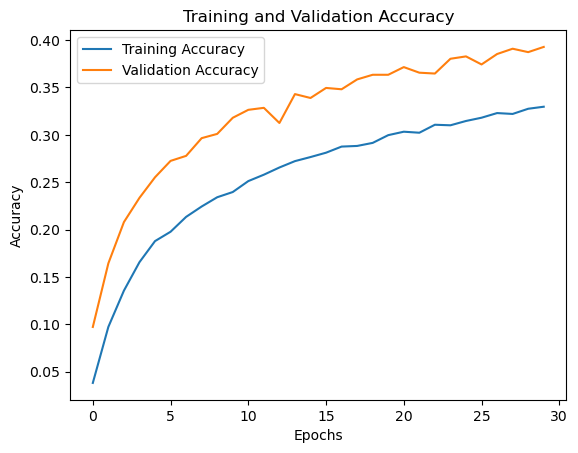

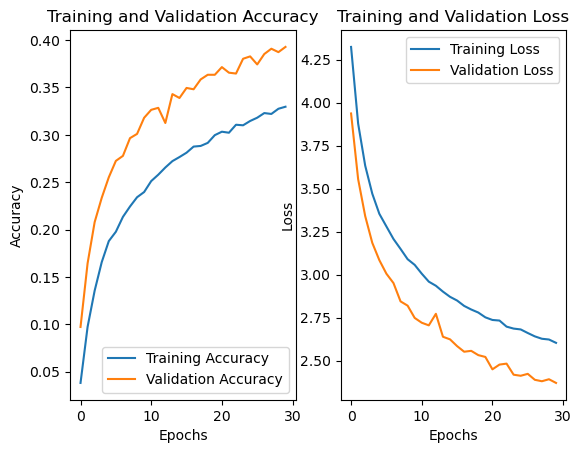

In [7]:
# Step 5: Compile and Train the Model on Sub-Training and Validation Sets
model = create_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_sub_train, y_sub_train, epochs=30, batch_size=64, validation_data=(x_val, y_val))

# Plot Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Accuracy and Loss Plots
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
# Step 6: Re-Train the Model on Full Training Dataset
x_full_train = np.concatenate((x_sub_train, x_val))
y_full_train = np.concatenate((y_sub_train, y_val))

model = create_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history_full = model.fit(x_full_train, y_full_train, epochs=15, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 114s 137ms/step - accuracy: 0.0293 - loss: 4.4435 - val_accuracy: 0.1202 - val_loss: 3.8105
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 108s 138ms/step - accuracy: 0.0975 - loss: 3.8591 - val_accuracy: 0.1838 - val_loss: 3.4794
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 102s 130ms/step - accuracy: 0.1425 - loss: 3.5883 - val_accuracy: 0.2322 - val_loss: 3.2085
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 101s 129ms/step - accuracy: 0.1718 - loss: 3.4535 - val_accuracy: 0.2538 - val_loss: 3.1056
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 102s 130ms/step - accuracy: 0.1919 - loss: 3.3276 - val_accuracy: 0.2729 - val_loss: 2.9771
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 100s 128ms/step - accuracy: 0.2072 - loss: 3.2418 - val_accuracy: 0.2817 - val_loss: 2.9620
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 103s 132ms/step - accuracy: 0.2156 - loss: 3.1844 - val_accuracy: 0.2973 - val_loss: 2.8659
Epoch 8/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 115s 147ms/step - accuracy: 0.2289 -

In [10]:
# Step 7: Evaluate the Model on Test Dataset
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.3526 - loss: 2.5610
Test Loss: 2.5619776248931885
Test Accuracy: 0.3564999997615814


In [11]:
# Step 8: Save the Model in the Recommended Keras Format
model.save('cifar100_cnn_model.keras')

In [12]:
# Step 9: Generate Classification Report and Confusion Matrix
predictions = model.predict(x_test)
predicted_classes = predictions.argmax(axis=-1)
y_test_labels = y_test.argmax(axis=-1)

print("Classification Report on Test Data:")
print(classification_report(y_test_labels, predicted_classes, zero_division=1))

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.41      0.78      0.54       100
           1       0.40      0.37      0.38       100
           2       0.37      0.28      0.32       100
           3       0.33      0.14      0.20       100
           4       0.18      0.22      0.20       100
           5       0.29      0.40      0.34       100
           6       0.45      0.28      0.35       100
           7       0.41      0.30      0.34       100
           8       0.42      0.39      0.41       100
           9       0.63      0.45      0.53       100
          10       0.32      0.14      0.19       100
          11       0.36      0.16      0.22       100
          12       0.32      0.38      0.35       100
          13       0.37      0.30      0.33       100
          14       0.35      0.17      0.23       100
          15       0.25      0.15      0.19       100
   

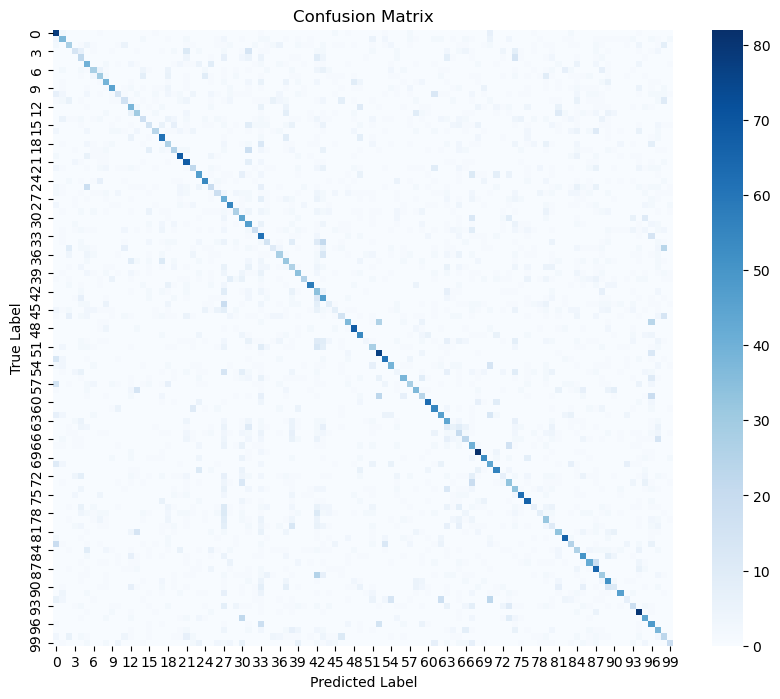

In [13]:
# Generate and Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, cmap='Blues', annot=False, fmt="d", cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()